In [33]:
from thesispy.elastix_wrapper.wrapper import run
from thesispy.elastix_wrapper.parameters import Parameters, Collection
from thesispy.experiments.validation import plot_cpoints
from pathlib import Path

2023-01-25 02:33:32,249 - Wrapper - INFO - Running elastix in: ../output/1674610412_learn_1_adaptivestochasticgradientdescent_246668
2023-01-25 02:33:34,450 - Validation - INFO - Calculating validation metrics for LEARN:
2023-01-25 02:33:34,451 - Validation - INFO - TRE: 19.90770585710138
2023-01-25 02:33:36,991 - Validation - INFO - Validation metrics calculated in 2.54s
2023-01-25 02:33:36,991 - Wrapper - INFO - Run ended. It took 4.7428 seconds


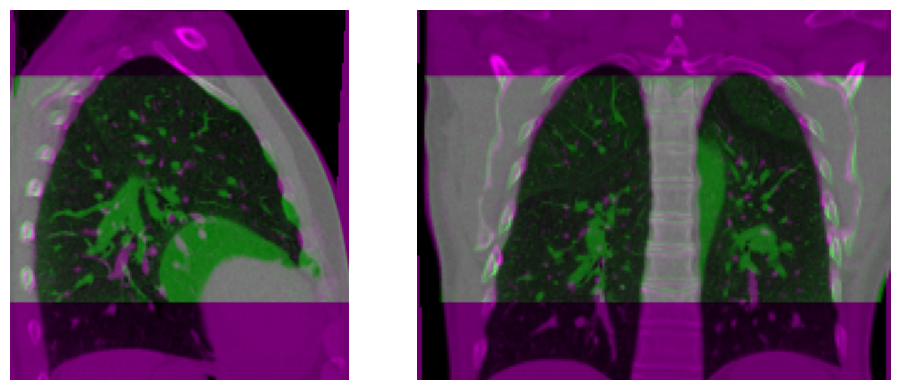

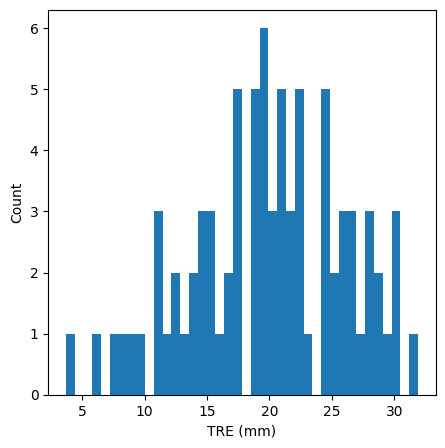

In [34]:
params = (
    Parameters.from_base(mesh_size=5, metric="AdvancedNormalizedCorrelation", seed=1, use_mask=False)
    .asgd()
    .multi_resolution(1, p_sched=[3], downsampling=True)
    .stopping_criteria(10)
    .instance(Collection.LEARN, 1)
)
run_result = run(params, Path("../output/" + str(params)), suppress_stdout=True, visualize=False, validate=True)

In [35]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

In [213]:
def plot_color_diff(moving, source, aspect, slice_tuple, invert_y=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    img1 = sitk.GetImageFromArray(moving[slice_tuple])
    img2 = sitk.GetImageFromArray(source[slice_tuple])
    img_min = np.min([img1, img2])
    img_max = np.max([img1, img2])

    img1_255 = sitk.Cast(sitk.IntensityWindowing(img1, windowMinimum=img_min, windowMaximum=img_max, 
                                                outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
    img2_255 = sitk.Cast(sitk.IntensityWindowing(img2, windowMinimum=img_min, windowMaximum=img_max, 
                                                outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)


    img3 = sitk.Cast(sitk.Compose(img1_255, img2_255, img1_255), sitk.sitkVectorUInt8)
    arr = sitk.GetArrayFromImage(img3)

    ax.imshow(np.swapaxes(arr, 0, 1), aspect=aspect)
    if invert_y:
        ax.invert_yaxis()
    else:
        ax.invert_xaxis()
    ax.set_ylim(30, 180)
    ax.axis("off")
    return fig

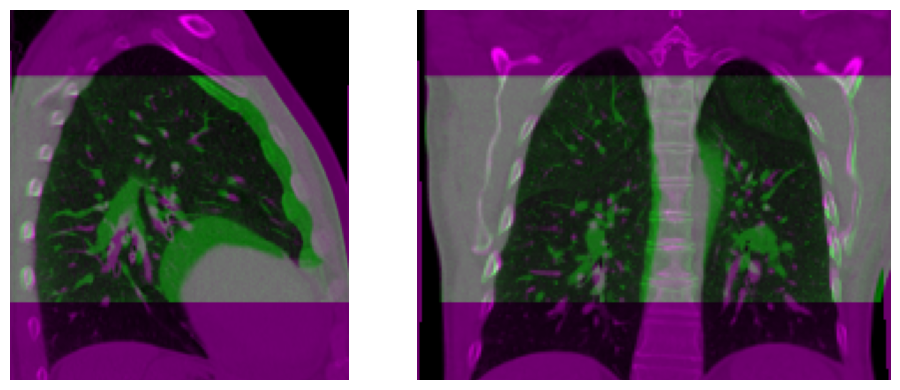

In [266]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_color_diff(run_result.deformed, fixed, 1.4, (50, slice(None), slice(None)), ax=axes[0])
plot_color_diff(run_result.deformed, fixed, 1.0, (slice(None), 50, slice(None)), invert_y=False, ax=axes[1])
fig.tight_layout()

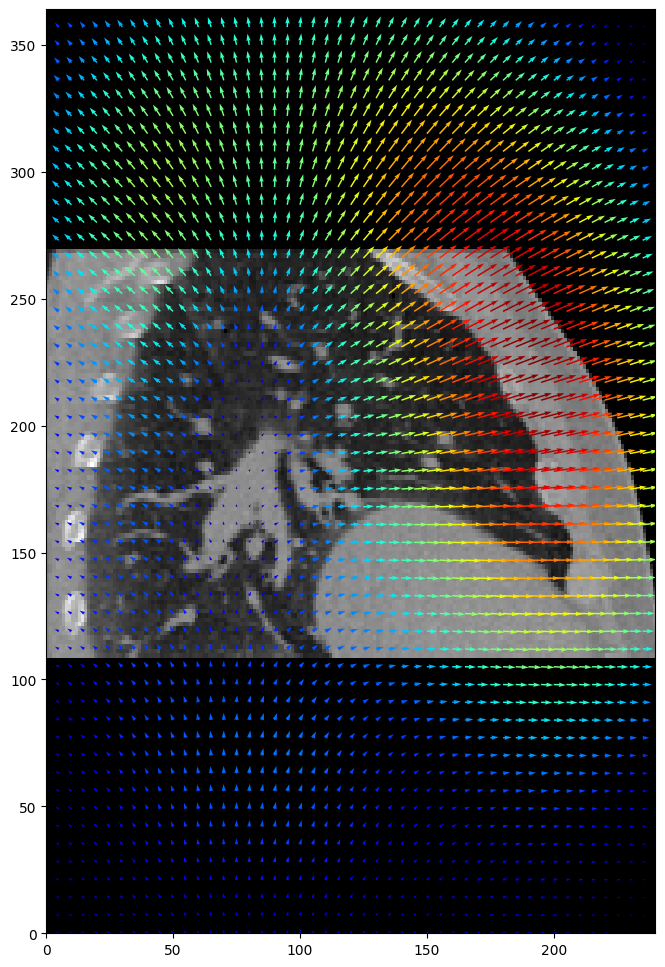

In [42]:
image = sitk.ReadImage("/home/joasiee/Documents/projects/instances/learn/scans/01_Fixed.nii.gz")
image_data = sitk.GetArrayFromImage(image)
image_slice = image_data[:,:,50]

spacing = image.GetSpacing()
size = image.GetSize()
extent = (0, size[1] * spacing[1], size[2] * spacing[2], 0)

plt.figure(figsize=(12,12))
t=plt.imshow(image_slice,extent=extent,interpolation=None)
plt.gca().invert_yaxis()
t.set_cmap("gray")

df = sitk.ReadImage("deformationField.mhd")
df_data = sitk.GetArrayFromImage(df)
df_slice = df_data[:,:,50,:]

orientation = df.GetDirection()
spacing = df.GetSpacing()

orientation = np.array(orientation).reshape((3,3))
voxel_to_physical = ( spacing * np.identity(3) ) @ orientation
physical_to_voxel = np.linalg.inv(voxel_to_physical)

for i in range(df_slice.shape[0]):
    for j in range(df_slice.shape[1]):
        p = physical_to_voxel @ df_slice[i,j]
        df_slice[i,j] = p

x = df_slice[:,:,1]
y = df_slice[:,:,2]

coordsX = np.arange(0, size[1] * spacing[1], size[1] * spacing[1] / float(df_data.shape[1]) )
coordsY = np.arange(0, size[2] * spacing[2], size[2] * spacing[2] / float(df_data.shape[0]) )

coordsX, coordsY = np.meshgrid(coordsX, coordsY)

zoom_f = 4
coordsX = coordsX[::zoom_f,::zoom_f]
coordsY = coordsY[::zoom_f,::zoom_f]
x = x[::zoom_f,::zoom_f]
y = y[::zoom_f,::zoom_f]

M = np.sqrt(x*x+y*y)

qq=plt.quiver(coordsX, coordsY, x, y, M, cmap=plt.cm.jet, units='xy', scale=1, angles='xy')

# # plt.axis('off')
# plt.show()

In [471]:
df_slice[:,:,1][::-1, ::-1]

array([[ 0.02151171,  0.0229362 ,  0.02442876, ..., -0.01586608,
        -0.0156233 , -0.01535844],
       [ 0.02301876,  0.02454219,  0.02613835, ..., -0.01801597,
        -0.01772141, -0.01740376],
       [ 0.02461268,  0.02624012,  0.02794516, ..., -0.02032896,
        -0.01997939, -0.01960562],
       ...,
       [ 0.04722103,  0.04898988,  0.05080286, ..., -0.19477189,
        -0.19339526, -0.19178247],
       [ 0.04428364,  0.04594335,  0.0476445 , ..., -0.18093815,
        -0.17966971, -0.1781809 ],
       [ 0.0414863 ,  0.043042  ,  0.04463658, ..., -0.16769664,
        -0.16653258, -0.1651632 ]], dtype=float32)

In [426]:
dvf.GetDirection()

(-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)

In [486]:
dvf

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f29a8e6aa90> >